In [1]:
# import numpy and pandas
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config Completer.use_jedi=False
import os

#import sklearn for cross validation|
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score,cross_validate

#import keras modules
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import keras
import keras.layers
from keras.layers import Layer 
import keras.initializers
from keras.models import Model, Sequential,load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Embedding, Lambda, Flatten, Multiply, multiply,dot, add,subtract
from keras.layers import Concatenate,concatenate,LeakyReLU,maximum,minimum
from keras.optimizers import Adam
from keras.regularizers import l2,l1
from keras.preprocessing import sequence
from keras.engine.topology import Layer, InputSpec

from keras.utils import plot_model
from IPython.display import SVG


from sklearn.metrics import precision_recall_curve, auc, roc_curve

#import rdkit
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols

#fix the random seed
np.random.seed(5)

import pickle
import random



Using TensorFlow backend.


In [2]:
GeneExpression_with_Symbol=pd.read_csv('/DAS_Storage4/ijjin/Study_2/CellLine/CCLE_expression_zscore.csv',index_col=0)
valid_gene_list=GeneExpression_with_Symbol.columns

In [3]:
GeneSet_List=[]
GeneSetFile='/DAS_Storage1/ijjin/Personal_studies/Drug-Cancer_reponse/geneset/c2.cp.kegg.v7.5.1.symbols.gmt'
with open(GeneSetFile) as f:
    reader = csv.reader(f)
    data = list(list(rec) for rec in csv.reader(f, delimiter='\t')) #reads csv into a list of lists
    for row in data:
        GeneSet_List.append(row)

GeneSet_Dic={}
for GeneSet in GeneSet_List:
    GeneSet_Dic[GeneSet[0]]=GeneSet[2:]
GeneSet_Dic_withoutNA={}
for GeneSet in GeneSet_Dic:
    GeneSet_tmp=pd.Series(GeneSet_Dic[GeneSet])
    GeneSet_tmp=GeneSet_tmp[GeneSet_tmp.isin(valid_gene_list)]
    GeneSet_Dic_withoutNA[GeneSet]=GeneSet_tmp




In [4]:
NCI60=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/221031_NCI60_median_with_raw_parameter.csv',index_col=0)

In [5]:
NCI60

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope
0,1,786O,-2.0,1.916247,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
1,1,786O,-1.0,2.006393,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
2,1,786O,0.0,2.069248,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
3,1,786O,1.0,2.066457,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
4,1,786O,2.0,0.079399,2.069248,6,2.079294,8.986296e-18,1.524922,3.000000
...,...,...,...,...,...,...,...,...,...,...
4737369,783538,UACC62,-4.0,1.966015,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316
4737370,783538,UACC62,-3.0,2.040921,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316
4737371,783538,UACC62,-2.0,1.398113,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316
4737372,783538,UACC62,-1.0,0.613998,2.040921,5,2.042580,3.025320e-01,-1.727939,2.277316


In [6]:
NCI60_randomized=NCI60.sample(frac=1)
NCI60_randomized=NCI60_randomized.reset_index(drop=True)

In [7]:
K.clear_session()
def get_session(gpu_fraction=0.1):

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    return tf.Session(config=tf.ConfigProto(allow_soft_placement=True,gpu_options=gpu_options))

KTF.set_session(get_session())


2022-11-07 13:12:28.369496: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-07 13:12:28.407752: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299915000 Hz
2022-11-07 13:12:28.412059: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x697bb90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-07 13:12:28.412107: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-11-07 13:12:28.417133: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-07 13:12:28.536483: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x697dc30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-07 13:12:28.536534: I tensorflow/compiler/xla/service/ser

In [8]:
X_origin=[pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/CellLine/Input/'+str(x)+'.csv',index_col=0) for x in range(len(GeneSet_Dic_withoutNA))]
Drug=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Drug/NCI60_compound_Morgan512.csv',index_col=0)


In [9]:
NCI60_filtered=NCI60_randomized

In [10]:
test_Response_list=range(0,int(len(NCI60_filtered)*1/10))
training_Response_list=range(int(len(NCI60_filtered)*1/10),int(len(NCI60_filtered)*9/10))
validation_Response_list=range(int(len(NCI60_filtered)*9/10),(len(NCI60_filtered)))


In [11]:
#relu
def Making_Model():
    #model_parameter=load_model('/DAS_Storage4/ijjin/Study_2/Single/NCI60_March22/Parameter/Model/220507_training_validation.hdf5',compile=False)

    #Make Model for each gene set, that consists of multiple genes_attention by built-in(2019/05/08)
    initializer = tf.keras.initializers.he_uniform()

    #Drug level
    Drug_feature_length=512
    Drug_Input=Input((Drug_feature_length,), dtype='float32', name='Drug_Input')
    Drug_Input=Input((Drug_feature_length,), dtype='float32')

    Drug_Dense1=Dense(256, name='Drug_Dense_1',kernel_initializer=initializer)(Drug_Input)
    Drug_Dense1=BatchNormalization()(Drug_Dense1)
    Drug_Dense1=Activation('relu', name='Drug_RELU_1')(Drug_Dense1)

    Drug_Dense2=Dense(128, name='Drug_Dense_2',kernel_initializer=initializer)(Drug_Dense1)
    Drug_Dense2=BatchNormalization()(Drug_Dense2)
    Drug_Dense2=Activation('relu', name='Drug_RELU_2')(Drug_Dense2)

    Drug_Dense_New1=Dense(128, name='Drug_Dense_New1',kernel_initializer=initializer)(Drug_Input)
    Drug_Dense_New1=BatchNormalization()(Drug_Dense_New1)
    Drug_Dense_New1=Activation('relu', name='Drug_RELU_New1')(Drug_Dense_New1)

    Drug_Dense_New2=Dense(32, name='Drug_Dense_New2',kernel_initializer=initializer)(Drug_Dense_New1)
    Drug_Dense_New2=BatchNormalization()(Drug_Dense_New2)
    Drug_Dense_New2=Activation('relu', name='Drug_RELU_New2')(Drug_Dense_New2)
    
    #Gene level
    GeneSet_Model=[]
    GeneSet_Input=[]
    for GeneSet in GeneSet_Dic_withoutNA.keys():
        Gene_Input=Input(shape=(len(GeneSet_Dic_withoutNA[GeneSet]),),dtype='float32', name=GeneSet+'_Input')
        
        Drug_effected_Model_for_Attention=[Gene_Input]
        Drug_Dense_Geneset=Dense(int(len(GeneSet_Dic_withoutNA[GeneSet])/4)+1,dtype='float32',name=GeneSet+'_Drug',kernel_initializer=initializer)(Drug_Dense_New2)
        Drug_Dense_Geneset=BatchNormalization(name=GeneSet+'_Drug_Batch')(Drug_Dense_Geneset)
        Drug_Dense_Geneset=Activation('relu', name=GeneSet+'Drug_RELU')(Drug_Dense_Geneset)
        Drug_effected_Model_for_Attention.append(Drug_Dense_Geneset) #Drug feature to attention layer
        Gene_Concat=concatenate(Drug_effected_Model_for_Attention,axis=1,name=GeneSet+'_Concat')
        Gene_Attention = Dense(len(GeneSet_Dic_withoutNA[GeneSet]), activation='tanh', name=GeneSet+'_Attention_Dense',kernel_initializer=initializer)(Gene_Concat)
        Gene_Attention=Activation(activation='softmax', name=GeneSet+'_Attention_Softmax')(Gene_Attention)
        Attention_Dot=dot([Gene_Input,Gene_Attention],axes=1,name=GeneSet+'_Dot')
        Attention_Dot=BatchNormalization(name=GeneSet+'_BatchNormalized')(Attention_Dot)
        Attention_Dot=Activation('relu',name=GeneSet+'_RELU')(Attention_Dot)
        GeneSet_Model.append(Attention_Dot)
        GeneSet_Input.append(Gene_Input)

    Drug_effected_Model_for_Attention=GeneSet_Model.copy()
    
    
    Drug_Dense_Sample=Dense(int(len(GeneSet_Dic_withoutNA)/16)+1,dtype='float32',name='Sample_Drug_Dense',kernel_initializer=initializer)(Drug_Dense_New2)
    Drug_Dense_Sample=BatchNormalization(name=GeneSet+'Sample_Drug_Batch')(Drug_Dense_Sample)
    Drug_Dense_Sample=Activation('relu', name='Sample_Drug_ReLU')(Drug_Dense_Sample)    #Drug feature to attention layer
    Drug_effected_Model_for_Attention.append(Drug_Dense_Sample)
    
    GeneSet_Concat=concatenate(GeneSet_Model,axis=1, name='GeneSet_Concatenate')
    Drug_effected_Concat=concatenate(Drug_effected_Model_for_Attention,axis=1, name='Drug_effected_Concatenate')
    Sample_Attention=Dense(len(GeneSet_Dic_withoutNA.keys()),activation='tanh', name='Sample_Attention_Dense',kernel_initializer=initializer)(Drug_effected_Concat)
    Sample_Attention=Activation(activation='softmax', name='Sample_Attention_Softmax')(Sample_Attention)
    Sample_Multiplied=multiply([GeneSet_Concat,Sample_Attention], name='Sample_Attention_Multiplied')
    Sample_Multiplied=BatchNormalization(name='Sample_Attention_BatchNormalized')(Sample_Multiplied)
    Sample_Multiplied=Activation('relu',name='Sample_Attention_Relu')(Sample_Multiplied)
    
    Input_for_model=[]
    for GeneSet_f in GeneSet_Input:
        Input_for_model.append(GeneSet_f)
    Input_for_model.append(Drug_Input)
    
    Dose_Input=Input((1,), dtype='float32', name='Dose_Input')
    Input_for_model.append(Dose_Input)

    Total_model=[Sample_Multiplied,Drug_Dense2]
    Model_Concat=concatenate(Total_model,axis=1, name='Total_Concatenate')
    Concated=Dense(128, name='Total_Dense')(Model_Concat)
    Concated=BatchNormalization(name='Total_BatchNormalized')(Concated)
    Concated=Activation(activation='relu', name='Total_RELU')(Concated)
    
    Final=Dense(32, name='Output_Dense1',kernel_initializer=initializer)(Concated)
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU')(Final)
    Final=Dense(8,name='Output_Dense2',kernel_initializer=initializer)(Final)
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU2')(Final)
    Final=Dense(2, name='Output_Dense3',kernel_initializer=initializer)(Final)    
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU3')(Final)
    
    Final_y_max=Dense(1, name='y_max',kernel_initializer=initializer)(Final)
    Final_y_min=Dense(1, name='y_min',kernel_initializer=initializer)(Final)
    Final_slope=Dense(1, name='slope',kernel_initializer=initializer)(Final)
    Final_IC50=Dense(1, name='IC50',kernel_initializer=initializer)(Final)

    Final_1=subtract([Dose_Input,Final_IC50],name='Final_1')
    Final_2=multiply([Final_slope,Final_1],name='Final_2')
    Final_negative=Lambda(lambda x:-1*x)(Final_2)
    Final_Sigmoid=Activation(activation='sigmoid',name='Final_Sigmoid')(Final_negative)
    Final_scale=subtract([Final_y_max,Final_y_min],name='Final_scale')
    Final_scale=Activation(activation='relu',name='Final_scale_activation')(Final_scale)
    Final_3=multiply([Final_scale,Final_Sigmoid],name='Final_3')
    Final_4=add([Final_3,Final_y_min],name='Final_4')
    model=Model(inputs=Input_for_model,outputs=Final_4)

    return model


In [12]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='loss', min_delta=0.0005, factor=0.1, patience=10, min_lr=0, verbose=1)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20, min_delta=0.0005, restore_best_weights=True)


In [13]:
class HiDRA_DataGenerator(keras.utils.Sequence):
    def __init__(self, idxs, batch_size=1024, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.idxs = idxs
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.idxs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        idxs_tmp = [self.idxs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(idxs_tmp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.idxs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs_tmp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        # Generate data
        NCI60_float_gen=NCI60_filtered.iloc[idxs_tmp]
        X_origin_tmp=[df.loc[NCI60_float_gen['CellName']] for df in X_origin]
        X_origin_tmp.append(Drug.loc[NCI60_float_gen['NSC']])
        Dose_df=pd.DataFrame(NCI60_float_gen['CONCENTRATION'])
        X_origin_tmp.append(Dose_df)
        Y_origin_tmp=NCI60_float_gen['AVERAGE_GIPRCNT']

        return X_origin_tmp, Y_origin_tmp

In [14]:
NCI60_filtered=NCI60_filtered.reset_index(drop=True)

In [15]:
def plcc_loss(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - r 

def aggregated_loss(y_true,y_pred):
    mse_value=tf.keras.metrics.mse(y_true,y_pred)
    pearson_loss=plcc_loss(y_true,y_pred)
    return mse_value+pearson_loss
    
    
def plcc_metric(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    return r_num / r_den


In [16]:
#test
model2=Making_Model()
model2.compile(loss=aggregated_loss,optimizer=keras.optimizers.Adam(lr=0.01),metrics=[plcc_metric,'mean_squared_error'])


In [17]:
NCI60_filtered

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope
0,4518,KM12,1.0000,1.034569,2.049053,5,2.099319,8.219485e-01,-0.278687,3.000000
1,674102,UACC257,-2.0000,1.952976,1.952976,5,1.912630,1.000310e-01,1.030786,2.092798
2,666660,OVCAR4,-2.0000,2.040612,2.078281,5,2.079099,3.622170e-17,1.283848,3.000000
3,699491,NIHOVCAR3,1.3979,1.071269,1.996271,12,1.976040,2.916764e-01,0.074183,1.000000
4,701758,786O,0.0000,2.026348,2.026348,5,1.978109,1.325838e+00,1.626795,3.000000
...,...,...,...,...,...,...,...,...,...,...
4737369,147811,HCT116,-2.0000,2.024697,2.078496,5,2.081552,6.362993e-01,0.525233,1.960788
4737370,732731,NIHOVCAR3,-2.0000,1.978422,1.978422,5,1.998067,8.412381e-31,1.550210,3.000000
4737371,689184,A498,2.0000,1.332236,2.096231,5,2.003508,6.697522e-01,2.000000,3.000000
4737372,660812,KM12,0.0000,1.990000,2.022000,5,2.013793,1.427302e+00,1.033655,3.000000


In [18]:
full_generator=HiDRA_DataGenerator(NCI60_filtered.index)

In [ ]:
#New dataset(GIPRCNT) on New model with MinMax_Training whole dataset (y_max=2)
hist=model2.fit_generator(generator=full_generator, steps_per_epoch=len(NCI60_filtered) // 1024, epochs=2000,verbose=1,use_multiprocessing=True,workers=10,callbacks=[reduce_lr,es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2000






2022-11-07 13:21:50.367559: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


4626/4626 [==============================] - 4367s 944ms/step - loss: 0.1858 - plcc_metric: 0.8852 - mean_squared_error: 0.0710
Epoch 2/2000
4626/4626 [==============================] - 4314s 933ms/step - loss: 0.1081 - plcc_metric: 0.9335 - mean_squared_error: 0.0417
Epoch 3/2000
4626/4626 [==============================] - 4540s 982ms/step - loss: 0.0962 - plcc_metric: 0.9410 - mean_squared_error: 0.0372
Epoch 4/2000
4626/4626 [==============================] - 4198s 907ms/step - loss: 0.0897 - plcc_metric: 0.9450 - mean_squared_error: 0.0347
Epoch 5/2000
4626/4626 [==============================] - 4078s 881ms/step - loss: 0.0858 - plcc_metric: 0.9475 - mean_squared_error: 0.0333
Epoch 6/2000
 188/4626 [>.............................] - ETA: 1:02:49 - loss: 0.0817 - plcc_metric: 0.9500 - mean_squared_error: 0.0317

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4626/4626 [==============================] - 4083s 883ms/step - loss: 0.0830 - plcc_metric: 0.9492 - mean_squared_error: 0.0322
Epoch 7/2000
2288/4626 [=============>................] - ETA: 36:51 - loss: 0.0806 - plcc_metric: 0.9507 - mean_squared_error: 0.0313

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4111/4626 [=========================>....] - ETA: 8:23 - loss: 0.0790 - plcc_metric: 0.9517 - mean_squared_error: 0.0307

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4626/4626 [==============================] - 4524s 978ms/step - loss: 0.0777 - plcc_metric: 0.9525 - mean_squared_error: 0.0302
Epoch 10/2000
1494/4626 [========>.....................] - ETA: 50:34 - loss: 0.0757 - plcc_metric: 0.9538 - mean_squared_error: 0.0294

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3384/4626 [====================>.........] - ETA: 18:39 - loss: 0.0753 - plcc_metric: 0.9540 - mean_squared_error: 0.0293

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4626/4626 [==============================] - 4071s 880ms/step - loss: 0.0745 - plcc_metric: 0.9545 - mean_squared_error: 0.0290
Epoch 13/2000
 762/4626 [===>..........................] - ETA: 58:13 - loss: 0.0724 - plcc_metric: 0.9558 - mean_squared_error: 0.0282

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4626/4626 [==============================] - 4103s 887ms/step - loss: 0.0737 - plcc_metric: 0.9550 - mean_squared_error: 0.0287
Epoch 14/2000
2804/4626 [=================>............] - ETA: 26:54 - loss: 0.0727 - plcc_metric: 0.9556 - mean_squared_error: 0.0282

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4626/4626 [==============================] - 4080s 882ms/step - loss: 0.0724 - plcc_metric: 0.9558 - mean_squared_error: 0.0281
Epoch 16/2000
 195/4626 [>.............................] - ETA: 1:07:42 - loss: 0.0696 - plcc_metric: 0.9574 - mean_squared_error: 0.0270

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4626/4626 [==============================] - 4110s 888ms/step - loss: 0.0717 - plcc_metric: 0.9562 - mean_squared_error: 0.0279
Epoch 17/2000
2241/4626 [=============>................] - ETA: 35:17 - loss: 0.0706 - plcc_metric: 0.9569 - mean_squared_error: 0.0275

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4626/4626 [==============================] - 4107s 888ms/step - loss: 0.0707 - plcc_metric: 0.9568 - mean_squared_error: 0.0275
Epoch 19/2000
4626/4626 [==============================] - 4300s 929ms/step - loss: 0.0703 - plcc_metric: 0.9571 - mean_squared_error: 0.0274
Epoch 20/2000
4626/4626 [==============================] - 4532s 980ms/step - loss: 0.0698 - plcc_metric: 0.9573 - mean_squared_error: 0.0272
Epoch 21/2000
4626/4626 [==============================] - 3997s 864ms/step - loss: 0.0694 - plcc_metric: 0.9576 - mean_squared_error: 0.0270
Epoch 22/2000
4626/4626 [==============================] - 3651s 789ms/step - loss: 0.0690 - plcc_metric: 0.9578 - mean_squared_error: 0.0269
Epoch 23/2000
4626/4626 [==============================] - 3677s 795ms/step - loss: 0.0687 - plcc_metric: 0.9580 - mean_squared_error: 0.0268
Epoch 24/2000
4626/4626 [==============================] - 3991s 863ms/step - loss: 0.0683 - plcc_metric: 0.9583 - mean_squared_error: 0.0266
Epoch 25/2000
4626/4

In [ ]:
pd.DataFrame(hist.history).to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Full/221107_Full.csv')

In [ ]:
model2.save('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Model/221107_Full.hdf5')

In [24]:
pd.DataFrame(hist.history)

,loss,plcc_metric,mean_squared_error,lr
0,0.185814,0.885176,0.070991,0.01000
1,0.108133,0.933542,0.041675,0.01000
2,0.096150,0.941022,0.037173,0.01000
3,0.089750,0.945000,0.034750,0.01000
4,0.085800,0.947470,0.033270,0.01000
...,...,...,...,...
144,0.053252,0.967444,0.020697,0.00001
145,0.053231,0.967461,0.020691,0.00001
146,0.053233,0.967458,0.020691,0.00001
147,0.053218,0.967468,0.020686,0.00001


In [25]:
model2.evaluate_generator(full_generator)

[0.05127081531714012, 0.9686265089555164, 0.019897324272455188]

In [26]:
test_idx=full_generator.indexes
predicted_tmp=model2.predict_generator(full_generator)
predicted_tmp=[x[0] for x in predicted_tmp]

In [27]:
test_df=NCI60_filtered.iloc[test_idx]
test_df=test_df.iloc[0:len(predicted_tmp)]

In [28]:
test_df['predicted']=predicted_tmp

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


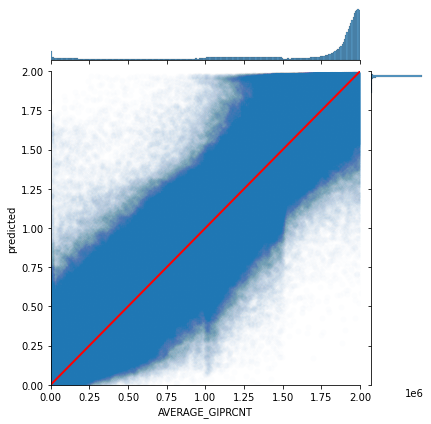

In [34]:
#new
plot=sns.jointplot(test_df.AVERAGE_GIPRCNT,test_df.predicted,alpha=0.01)
plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
plot.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Full/221108_NCI60_Full_a0.01.pdf')

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


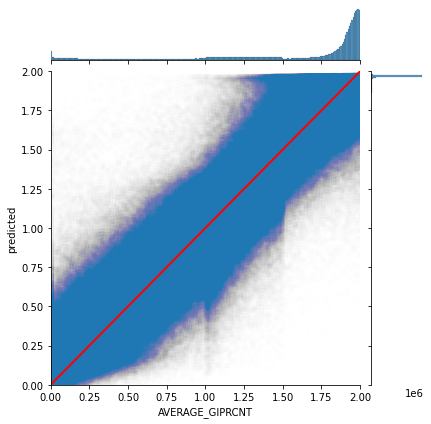

In [35]:
#new
plot=sns.jointplot(test_df.AVERAGE_GIPRCNT,test_df.predicted,alpha=0.002)
plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
plot.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Full/221108_NCI60_Full_a0.002.pdf')

In [32]:
NCI60_randomized_level_list=[]
scale=0.1
for i in range(int(2/scale)):
    NCI60_randomized_level_df=test_df[(test_df.AVERAGE_GIPRCNT>i*scale)*(test_df.AVERAGE_GIPRCNT<(i+1)*scale)]
    NCI60_randomized_level_list.append(NCI60_randomized_level_df)
len_min=min([len(df) for df in NCI60_randomized_level_list])
NCI60_randomized_level_list_new=[]
for df in NCI60_randomized_level_list:
    scale_each=len_min/len(df)
    df_new=df.sample(frac=scale_each)
    NCI60_randomized_level_list_new.append(df_new)
NCI60_balanced=pd.concat(NCI60_randomized_level_list_new)

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


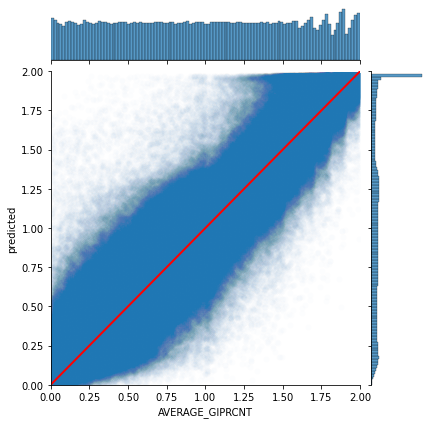

In [36]:
#new_scaled
plot=sns.jointplot(NCI60_balanced.AVERAGE_GIPRCNT,NCI60_balanced.predicted,alpha=0.01)
plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
plot.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Full/221108_NCI60_scaled.pdf')